Your submission should be a Jupyter notebook that executes the tasks below for at least the
following frames: biases, flats in all bands, darks, science frames for PG1633+099 and NGC6823.
1. Characterize and subtract the overscan.
2. Trim the frames so that only the 2048x2048 data section remains.
3. Create a master bias.
4. Subtract the master bias from all frames.
5. Save the frames with their original filename, plus the "otz" flags to indicate your overscan,
trim, and bias (aka zero) corrections.

In [51]:
#import packages 

from astropy.modeling import models, fitting
import scipy.optimize
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib as mpl
%matplotlib inline
from astropy.visualization import hist
from tempfile import mkdtemp
from pathlib import Path
from ccdproc import ImageFileCollection, Combiner, combine
import ccdproc as ccdp
from astropy.modeling import fitting
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D
from astropy.nddata import CCDData
import glob
from datetime import datetime
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import glob
import sys

path_dir = '/Users/mcgowkb1/ASTR8060/astr_8060_f23/software/ccd-reduction-and-photometry-guide/ccd-reduction-and-photometry-guide/notebooks/'
sys.path.insert(0,path_dir)
from convenience_functions import show_image

## Characterize and subtract the overscan

In [52]:
# Data Directory for Images folder

data_dir = '/Users/mcgowkb1/ASTR8060/Imaging/' #raw data 
reduced_dir = '/Users/mcgowkb1/ASTR8060/astr_8060_f23/reduced_data/10102023/' #processed data

In [53]:
# Create file/image IDs for each type

# ID for flats a005-010
flat_id = ['a'+ str(num).zfill(3) + '.fits' for num in np.arange(5,11)]
print(flat_id)
# ID for flats a011-063
flat2_id = ['a'+ str(num).zfill(3) + '.fits' for num in np.arange(11,64)]

# ID for PG1633+099 images a064-092
target1_id = ['a'+ str(num).zfill(3) + '.fits' for num in np.arange(64,93)]
#print(images_id)

# ID for bias a093-111
bias_id = ['a'+ str(num).zfill(3) + '.fits' for num in np.arange(93,112)]
#print(bias_id)

# ID for darks d001-015 
darks_id = ['d'+ str(num).zfill(3) + '.fits' for num in np.arange(1,16)]
#print(darks_id)

# ID for PG1633 images a130-139
target2a_id = ['a'+ str(num).zfill(3) + '.fits' for num in np.arange(130,140)]
#print(images_id)

# ID for PG1633 images a202-211
target2b_id = ['a'+ str(num).zfill(3) + '.fits' for num in np.arange(202,212)]
#print(images_id)

# ID for PG1633 images a221-246
target2c_id = ['a'+ str(num).zfill(3) + '.fits' for num in np.arange(221,247)]
#print(images_id)

# ID for NGC6823 images a153-163
target3_id =  ['a'+ str(num).zfill(3) + '.fits' for num in np.arange(153,164)]

['a005.fits', 'a006.fits', 'a007.fits', 'a008.fits', 'a009.fits', 'a010.fits']


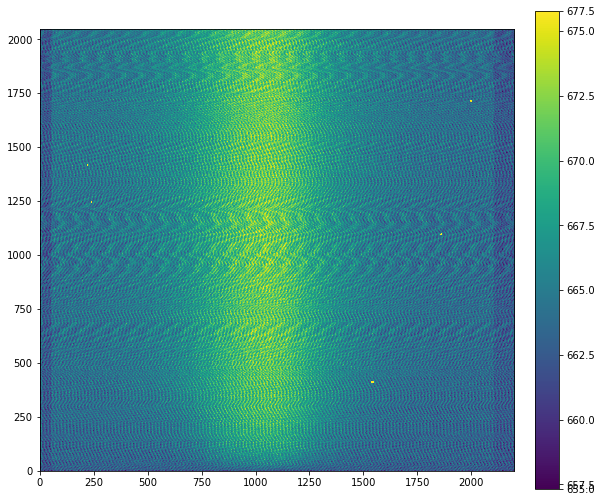

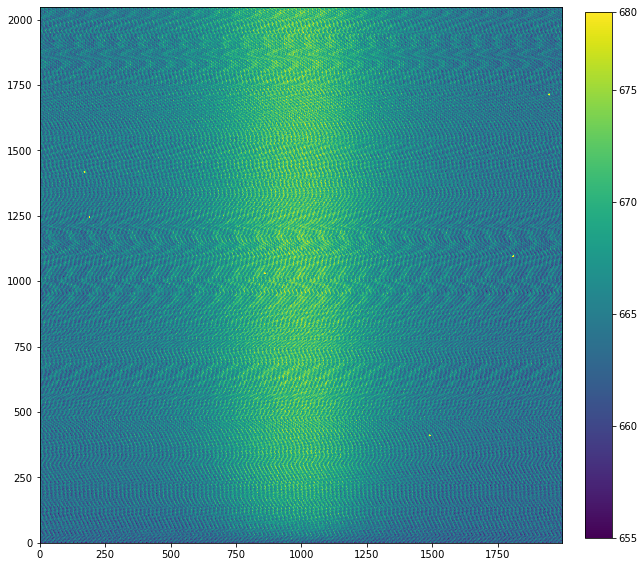

In [54]:
# Bias Sample 
hdu = fits.open(data_dir + 'a093.fits')
img = hdu[0].data
np.shape(img)
section = img[:,50:2048]
show_image(img)# before subtraction 
show_image(section)# after subtraction

center image RMS: 8.784649092360148 center image mean: 670.190064


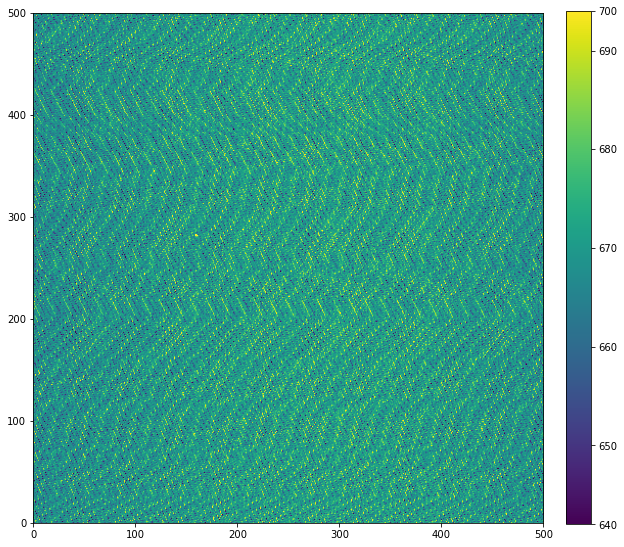

In [55]:
# Lets use the bias example 
# Bias Sample 
hdu = fits.open(data_dir + 'a093.fits')
img = hdu[0].data

np.shape(img)
section = img[:,50:2048]
hdr = hdu[0].header
#show_image(section)
#hdu.info()
#hdr

# Center image 
center_section = img[750:1250,750:1250]
show_image(center_section)

# We calculate the RMS to guide the overscan subtraction methods
img_rms = np.std(center_section)
img_mean = np.mean(center_section)
print('center image RMS:',img_rms,'center image mean:',img_mean)

In [56]:
# We look at the means to determine how the bias levels change throughout the night

bias_means = []
trim_means = []
for ids in bias_id:
    hdu = fits.open(data_dir + ids)
    img = hdu[0].data
    bias_sec = img[:,2100:2199] #overscan regions
    trim_sec = img[:,50:2048]  #science regions 
    bias_mean = np.mean(bias_sec)
    science_mean = np.mean(trim_sec)
    bias_means.append(bias_mean)
    trim_means.append(science_mean)
    

print(bias_means)
print(np.mean(bias_means))

print(trim_means)
print(np.mean(trim_means))

[662.6044231376262, 662.2916765309343, 662.3431828046085, 662.443541863952, 662.442565301452, 662.439423532197, 662.3853574810606, 662.3316564078283, 662.3642726089015, 662.326201467803, 662.3430644333964, 662.3391137941919, 662.3369584517045, 662.3923808396464, 662.3348770912247, 662.3629655934343, 662.3785067471591, 662.4254705255681, 662.418792416351]
662.3844437383706
[666.1347969062813, 665.8049130673643, 665.8597997411474, 665.9729917906187, 665.9631039731138, 665.9376063074793, 665.8916194026058, 665.8516160203172, 665.8775809500908, 665.8454235485485, 665.8634833564033, 665.8526199539383, 665.8491692375969, 665.8885132691285, 665.839160938282, 665.9042841669794, 665.8966635092123, 665.9291882214245, 665.9339671702953]
665.8998158700435


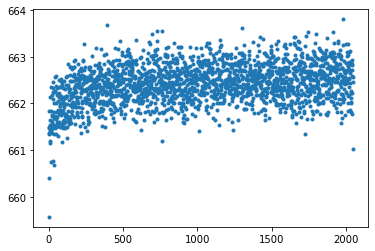

In [57]:
overscan_avg = np.mean(bias_sec,axis=1)
row = np.arange(0,2048)
plt.plot(row,overscan_avg,'.')

In [58]:
# We chose our model for the Overscan subtraction. In the previous notebook you can see the process used for choosing
# The final selection is the chebyshev

model_cheb = models.Chebyshev1D(degree=6)
model1 = model_cheb
fitter = fitting.LinearLSQFitter() 
best_fit1 = fitter(model1,row,overscan_avg)
best_fit1

<Chebyshev1D(6, c0=662.33897949, c1=0.32120003, c2=-0.2166516, c3=0.14155447, c4=-0.09693102, c5=0.05103386, c6=-0.04722347, domain=(0.0, 2047.0))>

0.38619955099974235 Chebyshev RMS


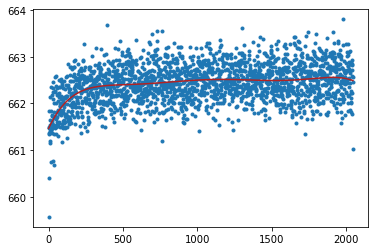

In [59]:
# Plot the fitting 
plt.plot(row,overscan_avg,'.')
plt.plot(row,best_fit1(row), linestyle = '-',c='firebrick')
new_rms1 = np.std(overscan_avg - best_fit1(row))
print(new_rms1, 'Chebyshev RMS')


In [60]:
# Make a temporary folder as a path object
image_folder = Path(mkdtemp())

# Overscan Subtraction w/ trim
for ids in bias_id:
    img = CCDData.read(data_dir + ids, hdu=0, unit="adu")
    img_ot = ccdp.subtract_overscan(img,fits_section='[2141:2200,1:2048]', model = model1) # Overscan Subtraction (rows and columns flipped)
    img_otz = ccdp.trim_image(img_ot[:,50:2098]) # Trim Image
    img_otz.write(image_folder/f'otz_{ids}',overwrite=True)
    img_otz.write('/Users/mcgowkb1/ASTR8060/astr_8060_f23/reduced_data/10102023/'+ f'otz_{ids}', overwrite = True)

ifc = ImageFileCollection(image_folder)
ifc.summary

file,simple,bitpix,naxis,naxis1,naxis2,origin,date,iraf-tlm,datamin,datamax,object,date-obs,timesys,observat,sidetime,objepoch,airmass,exptime,ha,telescop,instrume,filter1,filter2,telra,teldec,observer,subtract_overscan,suboscan,trim_image,trimim,bunit,comment
str13,bool,int64,int64,int64,int64,str37,str19,str21,float64,float64,str7,str23,str3,str11,str10,float64,float64,float64,str9,str9,str10,str4,str4,str11,str12,str8,str8,str231,str6,str13,str3,str19
otz_a093.fits,True,-64,2,2048,2048,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:56:40,09:56:39 (15/09/2009),572.0,7536.0,SERVICE,2009-06-23T04:19:45.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,0.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,suboscan,"ccd=<CCDData>, fits_section=[2141:2200,1:2048], model=Model: Chebyshev1DInputs: ('x',)Outputs: ('y',)Model set size: 1Degree: 6Parameters: c0 c1 c2 c3 c4 c5 c6 --- --- --- --- --- --- --- 0.0 0.0 0.0 0.0 0.0 0.0 0.0",trimim,ccd=<CCDData>,adu,"None,None,None,None"
otz_a094.fits,True,-64,2,2048,2048,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:56:41,09:56:40 (15/09/2009),586.0,1338.0,SERVICE,2009-06-23T04:20:09.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,0.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,suboscan,"ccd=<CCDData>, fits_section=[2141:2200,1:2048], model=Model: Chebyshev1DInputs: ('x',)Outputs: ('y',)Model set size: 1Degree: 6Parameters: c0 c1 c2 c3 c4 c5 c6 --- --- --- --- --- --- --- 0.0 0.0 0.0 0.0 0.0 0.0 0.0",trimim,ccd=<CCDData>,adu,"None,None,None,None"
otz_a095.fits,True,-64,2,2048,2048,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:56:42,09:56:41 (15/09/2009),587.0,1653.0,SERVICE,2009-06-23T04:20:33.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,0.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,suboscan,"ccd=<CCDData>, fits_section=[2141:2200,1:2048], model=Model: Chebyshev1DInputs: ('x',)Outputs: ('y',)Model set size: 1Degree: 6Parameters: c0 c1 c2 c3 c4 c5 c6 --- --- --- --- --- --- --- 0.0 0.0 0.0 0.0 0.0 0.0 0.0",trimim,ccd=<CCDData>,adu,"None,None,None,None"
otz_a096.fits,True,-64,2,2048,2048,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:56:44,09:56:42 (15/09/2009),579.0,1473.0,SERVICE,2009-06-23T04:20:58.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,0.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,suboscan,"ccd=<CCDData>, fits_section=[2141:2200,1:2048], model=Model: Chebyshev1DInputs: ('x',)Outputs: ('y',)Model set size: 1Degree: 6Parameters: c0 c1 c2 c3 c4 c5 c6 --- --- --- --- --- --- --- 0.0 0.0 0.0 0.0 0.0 0.0 0.0",trimim,ccd=<CCDData>,adu,"None,None,None,None"
otz_a097.fits,True,-64,2,2048,2048,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:56:44,09:56:44 (15/09/2009),587.0,3757.0,SERVICE,2009-06-23T04:21:22.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,0.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,suboscan,"ccd=<CCDData>, fits_section=[2141:2200,1:2048], model=Model: Chebyshev1DInputs: ('x',)Outputs: ('y',)Model set size: 1Degree: 6Parameters: c0 c1 c2 c3 c4 c5 c6 --- --- --- --- --- --- --- 0.0 0.0 0.0 0.0 0.0 0.0 0.0",trimim,ccd=<CCDData>,adu,"None,None,None,None"
otz_a098.fits,True,-64,2,2048,2048,NOAO-IRAF FITS Image Kernel July 2003,2009-09-15T15:56:45,09:56:44 (15/09/2009),587.0,1268.0,SERVICE,2009-06-23T04:21:46.000,UTC,Observatory,21:52:56.8,2000.0,4.101808827966386,0.0,0:1:20.24,Telescope,Instrument,None,None,21:51:36.56,-34:39:29.75,Observer,suboscan,"ccd=<CCDData>, fits_section=[2141:2200,1:2048], model=Model: Chebyshev1DInputs: ('x',)Outputs: ('y',)Model set size: 1Degree: 6Parameters: c0 c1 c2 c3 c4 c5 c6 --- --- --- --- --- --- --- 0.0 0.0 0.0 0.0 0.0 0.0 0.0",trimim,ccd=<CCDData>,adu,"None,None,None,None"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
otz_a105.fits,True,

## Create a Master Bias

(2048, 2048)


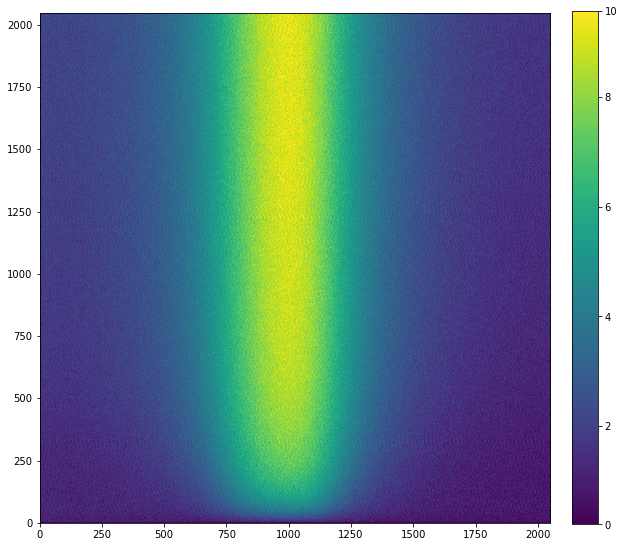

In [61]:
# For this case we have decided its appropriate to combine all bias into a master using the 'median'

avg_combo = combine(ifc.ccds(),method = 'median')
show_image(avg_combo)
master_bias = avg_combo
print(np.shape(avg_combo))

## Subtract the Master Bias & Save Processed Images w/ OTZ Flags

In [62]:
# Function takes in a list of ids for the fits images
# Function subtracts overscan, trims image, and subtracts the master bias from each image
# Function writes out/saves images with flags 
def processing_function(image_ids):

    # Overscan Subtraction and trim prepping for master bias subtraction 
    for ids in image_ids:
        img = CCDData.read(data_dir + ids, hdu=0, unit="adu")
        img_ot = ccdp.subtract_overscan(img,fits_section='[2141:2200,1:2048]', model = model1) #rows and columns flipped
        img_otz = ccdp.trim_image(img_ot[:,50:2098]) #check size/shape
        no_bias_frame = ccdp.subtract_bias(img_otz, master_bias) 
        no_bias_frame.write(reduced_dir + f'otz_{ids}',overwrite=True)

    #ifc = ImageFileCollection(prep_folder)
    return 

In [63]:
processing_function(flat_id)
processing_function(flat2_id)
processing_function(target1_id)
processing_function(target1_id)
processing_function(target2a_id)
processing_function(target2b_id)
processing_function(target2c_id)
processing_function(target3_id)


/Users/mcgowkb1/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mcgowkb1/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


LinAlgError: SVD did not converge in Linear Least Squares